In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import gamma as gamma_function
from numpy.fft import rfft, irfft
import time

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12
})

In [6]:
def bsm_price(S, K, T, r, q, sigma, flag):
    """
    Calculates the Black-Scholes-Merton option price.

    Parameters:
    ----------
    S: Underlying asset price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma: Volatility
    flag: Option type ('c' for call, 'p' for put)

    Returns:
    -------
    float
        The calculated price of the option.
    """
    # Handle edge cases with zero/near-zero time to maturity or volatility by returning intrinsic value.
    if T <= 1e-6 or sigma <= 1e-6:
        return np.maximum(0, S * np.exp(-q * T) - K * np.exp(-r * T)) if flag == 'c' else np.maximum(0, K * np.exp(-r * T) - S * np.exp(-q * T))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if flag == 'c':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_implied_vol(target_price, S, K, T, r, q, flag):
    """
    Calculates the implied volatility for an option.
    This is the volatility that makes the BSM price equal to the market price.

    Parameters:
    ----------
    price: Market price of the option
    S, K, T, r, q, flag: BSM model parameters

    Returns:
    -------
    float
        The implied volatility, or np.nan if not found.
    """
    # The objective is to find the root of: BSM_price(sigma) - target_price = 0
    objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, flag) - target_price
    
    try:
        # Use a numerical solver (Brent's method) to find the root for sigma
        # within a reasonable search range (e.g., 0.01% to 500%).
        return brentq(objective, 1e-4, 5.0)
    except (ValueError, RuntimeError): # If no root is found, return NaN
        return np.nan

def plot_with_nan_handling(x, y, **kwargs):
    """
    Plots data on a specific axes object, correctly handling NaN values by creating gaps in the line.
    It expects 'ax' to be passed as a keyword argument.
    """
    # Explicitly get the 'ax' object from kwargs and remove it so it's not passed to ax.plot
    ax = kwargs.pop('ax', plt.gca())
    
    plot_kwargs = kwargs # The rest of the kwargs are for plotting

    x = np.array(x)
    y = np.array(y)
    is_nan = np.isnan(y)
    
    start_idx = 0
    for i in range(1, len(y)):
        if is_nan[i] and not is_nan[i-1]: # End of a non-NaN segment
            ax.plot(x[start_idx:i], y[start_idx:i], **plot_kwargs)
            # Remove label for subsequent segments to avoid duplicates in legend
            if 'label' in plot_kwargs:
                del plot_kwargs['label']
        elif not is_nan[i] and is_nan[i-1]: # Start of a new non-NaN segment
            start_idx = i
    
    # Plot the last segment if it's not a NaN value
    if not is_nan[-1]:
        ax.plot(x[start_idx:], y[start_idx:], **plot_kwargs)

def price_rbergomi_piecewise_h(K, T, T1, H1, H2, eta, rho, xi, S0, r, q, n_steps, n_paths, rng):
    """
    Prices an option using the slow but theoretically consistent 'true memory' rBergomi model.
    This version correctly handles a time-varying Hurst parameter H(t) for both the
    stochastic process Y_t and its theoretical variance Var(Y_t) for the drift correction.

    This ensures the resulting variance process V_t is a true martingale under the risk-neutral measure.

    Args:
        K (float): Strike price.
        T (float): Time to maturity.
        T1 (float): The time at which the Hurst parameter regime switches (tau).
        H1 (float): Hurst parameter for the first regime [0, T1].
        H2 (float): Hurst parameter for the second regime (T1, T].
        eta (float): Volatility of volatility parameter.
        rho (float): Correlation between the two Brownian motions.
        xi (float): Initial forward variance (V_0).
        S0 (float): Initial stock price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        n_steps (int): Number of time steps for the simulation.
        n_paths (int): Number of Monte Carlo simulation paths.
        rng (np.random.Generator): An isolated random number generator instance to ensure
                                   simulations are independent and reproducible.
    """
    # Define the time step size for the Euler discretization.
    dt = T / n_steps
    # Create the discrete time grid for the simulation.
    t_grid = np.linspace(0, T, n_steps + 1)

    # --- Step 1: Generate fundamental random drivers ---
    # Generate the increments for two independent Brownian motions, W and W_perp.
    # dW drives the volatility process.
    # dW_perp is used to construct the correlated process for the stock price.
    # The provided 'rng' object ensures that simulations are isolated and reproducible.
    dW = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, n_steps))
    dW_perp = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, n_steps))

    # Construct the increments for the correlated Brownian motion dZ using a Cholesky-like decomposition.
    # dZ is correlated with dW with a correlation coefficient of rho.
    # dZ_t = rho * dW_t + sqrt(1 - rho^2) * dW_perp_t
    dZ = rho * dW + np.sqrt(1 - rho**2) * dW_perp

    # Define the piecewise-constant Hurst function H(t), which creates different roughness regimes.
    def H_func(t):
        """Returns the Hurst parameter based on the time t."""
        return H1 if t <= T1 else H2

    # --- Step 2: Generate the fractional stochastic process Y_paths ---
    # This simulates the fractional integral Y_t = integral from 0 to t of K(t,s) dW_s,
    # where the kernel K(t,s) depends on a time-varying Hurst parameter H(s).
    # Kernel K(t,s) = sqrt(2*H(s)) * (t-s)^(H(s)-0.5).
    # This is computationally intensive due to the nested loops (O(n_steps^2)).
    Y_paths = np.zeros((n_paths, n_steps + 1))
    # Loop over each time step t_i in the grid to calculate Y_{t_i}.
    for i in range(1, n_steps + 1):
        ti = t_grid[i]
        integral_sum = np.zeros(n_paths)
        # Inner loop approximates the integral by summing contributions from all past shocks dW_j.
        for j in range(i):
            tj = t_grid[j]
            # Crucially, the Hurst parameter is determined by the time of the past shock, H(s=tj).
            H_past = H_func(tj)
            # Calculate the value of the discretized fractional kernel.
            kernel_val = np.sqrt(2 * H_past) * (ti - tj)**(H_past - 0.5)
            # Add the contribution of this past shock to the integral sum for each path.
            integral_sum += kernel_val * dW[:, j]
        Y_paths[:, i] = integral_sum

    # --- Step 3: Calculate the theoretical variance for the drift correction ---
    # To ensure V_t is a martingale, its drift must be corrected by subtracting 0.5 * eta^2 * Var(Y_t).
    # This block computes the deterministic variance Var(Y_t) = integral from 0 to t of K(t,s)^2 ds.
    # The formula is: Var(Y_t) = integral from 0 to t of [2*H(s) * (t - s)^(2*H(s)-1)] ds.
    variance_drift = np.zeros(n_steps + 1)
    # Loop over each time step t_i to calculate Var(Y_{t_i}).
    for i in range(1, n_steps + 1):
        ti = t_grid[i]
        integral_sum_var = 0.0
        # Inner loop approximates the integral using a Riemann sum.
        for j in range(i):
            tj = t_grid[j]
            # Again, use the Hurst parameter from the time of integration, H(s=tj).
            H_s = H_func(tj)
            integrand = 2 * H_s * (ti - tj)**(2 * H_s - 1)
            integral_sum_var += integrand * dt
        variance_drift[i] = integral_sum_var

    # --- Step 4: Construct the Variance (V) process ---
    # The variance process is defined as V_t = xi * exp(eta * Y_t - 0.5 * eta^2 * Var(Y_t)).
    # We use the simulated Y_paths and the calculated variance_drift for this.
    # `np.newaxis` is used to broadcast the 1D variance_drift array to match the 2D Y_paths shape.
    V = xi * np.exp(eta * Y_paths - 0.5 * eta**2 * variance_drift[np.newaxis, :])

    # --- Step 5: Construct the final Stock Price (ST) ---
    # We solve for the terminal stock price ST by discretizing the SDE:
    # dS_t / S_t = (r - q) dt + sqrt(V_t) dZ_t
    # The solution is S_T = S_0 * exp( (r-q)T - 0.5 * integral_0^T V_s ds + integral_0^T sqrt(V_s) dZ_s ).
    # This is calculated efficiently for all paths using vectorized numpy operations.
    integral_V_dt = np.sum(V[:, :-1] * dt, axis=1)  # The Ito correction term integral.
    integral_sqrtV_dZ = np.sum(np.sqrt(V[:, :-1]) * dZ, axis=1) # The stochastic integral.
    
    ST = S0 * np.exp((r - q) * T - 0.5 * integral_V_dt + integral_sqrtV_dZ)

    # --- Step 6: Calculate the Option Price ---
    # Determine if the option is a call or a put based on its moneyness.
    # This is a simple heuristic; a more robust implementation might take an explicit flag.
    is_call = K >= S0
    if is_call:
        # Calculate call option payoffs for all paths.
        payoffs = np.maximum(ST - K, 0)
    else:
        # Calculate put option payoffs for all paths.
        payoffs = np.maximum(K - ST, 0)
    
    # The final option price is the discounted average of all simulated payoffs,
    # according to the principles of risk-neutral Monte Carlo pricing.
    option_price = np.mean(payoffs) * np.exp(-r * T)
    
    return option_price

def simulate_rbergomi_piecewise_h_path(T, T1, H1, H2, eta, rho, xi, S0, n_steps):
    """
    Simulates a single Variance (V_t) and Price (S_t) path for the rBergomi model
    with a piecewise-constant Hurst parameter (regime-switching).

    This function uses a theoretically consistent approach where the variance of the
    simulated fractional process Y_t matches its corresponding theoretical drift
    correction term, ensuring the variance process V_t is a martingale.

    Args:
        T (float): Total time to maturity.
        T1 (float): Time of the regime switch for the Hurst parameter.
        H1 (float): Hurst parameter for the first regime [0, T1].
        H2 (float): Hurst parameter for the second regime (T1, T].
        eta (float): Volatility of volatility.
        rho (float): Correlation between the two driving Brownian motions.
        xi (float): Initial forward variance (V_0).
        S0 (float): Initial stock price.
        n_steps (int): The number of time steps for the simulation.

    Returns:
        (tuple): A tuple containing (t_grid, S_path, V_path), which are the
                 time points, the simulated stock price path, and the variance path.
    """
    # --- Setup: Time Discretization ---
    # Calculate the size of each time step.
    dt = T / n_steps
    # Create the grid of time points from 0 to T.
    t_grid = np.linspace(0, T, n_steps + 1)

    # --- Step 1: Generate Correlated Brownian Increments ---
    # Generate increments for two independent Brownian motions, W and W_perp.
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    dW_perp = np.random.normal(0, np.sqrt(dt), n_steps)
    # Construct the correlated Brownian motion Z using correlation rho.
    # This is used to drive the stock price process.
    dZ = rho * dW + np.sqrt(1 - rho**2) * dW_perp

    # --- Step 2: Define the Piecewise-Constant Hurst Function ---
    # This function implements the regime switch for the model's "roughness".
    def H_func(t):
        """Returns the Hurst parameter H based on the time t."""
        return H1 if t <= T1 else H2

    # --- Step 3: Simulate the Fractional Process Y_t ---
    # This simulates the fractional integral Y_t = integral[0,t] K(t,s) dW_s,
    # where the kernel K(t,s) = sqrt(2H(s)) * (t-s)^(H(s)-0.5).
    # This nested loop is computationally intensive but theoretically correct.
    Y_path = np.zeros(n_steps + 1)
    for i in range(1, n_steps + 1):  # For each time step t_i...
        ti = t_grid[i]
        integral_sum = 0.0
        for j in range(i):  # ...sum the effects of all past shocks dW_j.
            tj = t_grid[j]
            # The kernel's roughness depends on the Hurst param at the time of the shock (tj).
            H_past = H_func(tj)
            kernel_val = np.sqrt(2 * H_past) * (ti - tj)**(H_past - 0.5)
            integral_sum += kernel_val * dW[j]
        Y_path[i] = integral_sum

    # --- Step 4: Calculate the Theoretical Variance of Y_t ---
    # This computes the deterministic drift correction term needed to make V_t a martingale.
    # The term is E[Y_t^2] = Var(Y_t) = integral[0,t] K(t,s)^2 ds.
    # This calculation must be consistent with the simulation in Step 3.
    variance_drift = np.zeros(n_steps + 1)
    for i in range(1, n_steps + 1):
        ti = t_grid[i]
        integral_sum_var = 0.0
        for j in range(i):
            tj = t_grid[j]
            H_s = H_func(tj)
            # The integrand is K(t,s)^2 = 2*H(s) * (t-s)^(2H(s)-1).
            integrand = 2 * H_s * (ti - tj)**(2 * H_s - 1)
            integral_sum_var += integrand * dt
        variance_drift[i] = integral_sum_var

    # --- Step 5: Construct the Variance and Stock Price Paths ---
    # Construct the variance path V_t = xi * exp(eta*Y_t - 0.5*eta^2*E[Y_t^2]).
    V_path = xi * np.exp(eta * Y_path - 0.5 * eta**2 * variance_drift)

    # Construct the stock price path S_t using a log-Euler scheme.
    # The SDE is dS_t/S_t = sqrt(V_t) dZ_t (assuming r=q=0 for path simulation).
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0
    for i in range(n_steps):
        # Ensure variance is non-negative to avoid sqrt(negative number) errors.
        V_t = np.maximum(V_path[i], 1e-12)
        # S_t+1 = S_t * exp(-0.5*V_t*dt + sqrt(V_t)*dZ_t)
        S_path[i+1] = S_path[i] * np.exp(-0.5 * V_t * dt + np.sqrt(V_t) * dZ[i])

    return t_grid, S_path, V_path


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


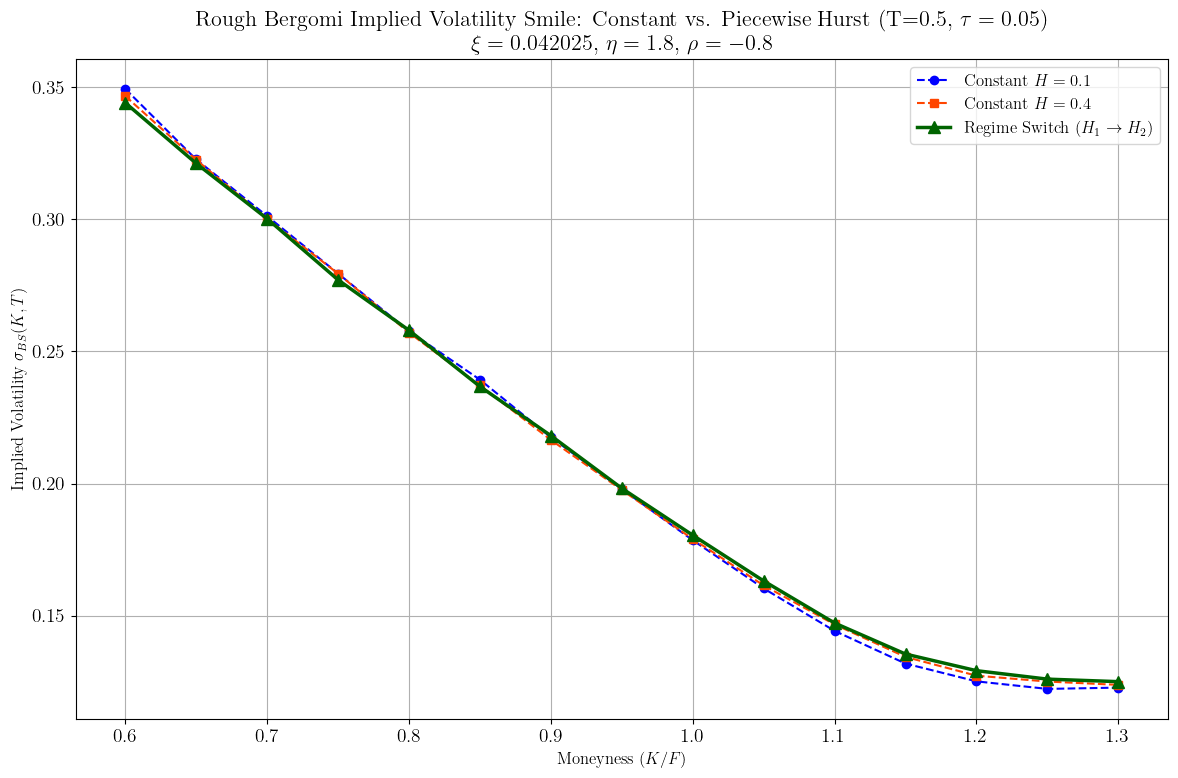

In [13]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 0.5, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.05
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


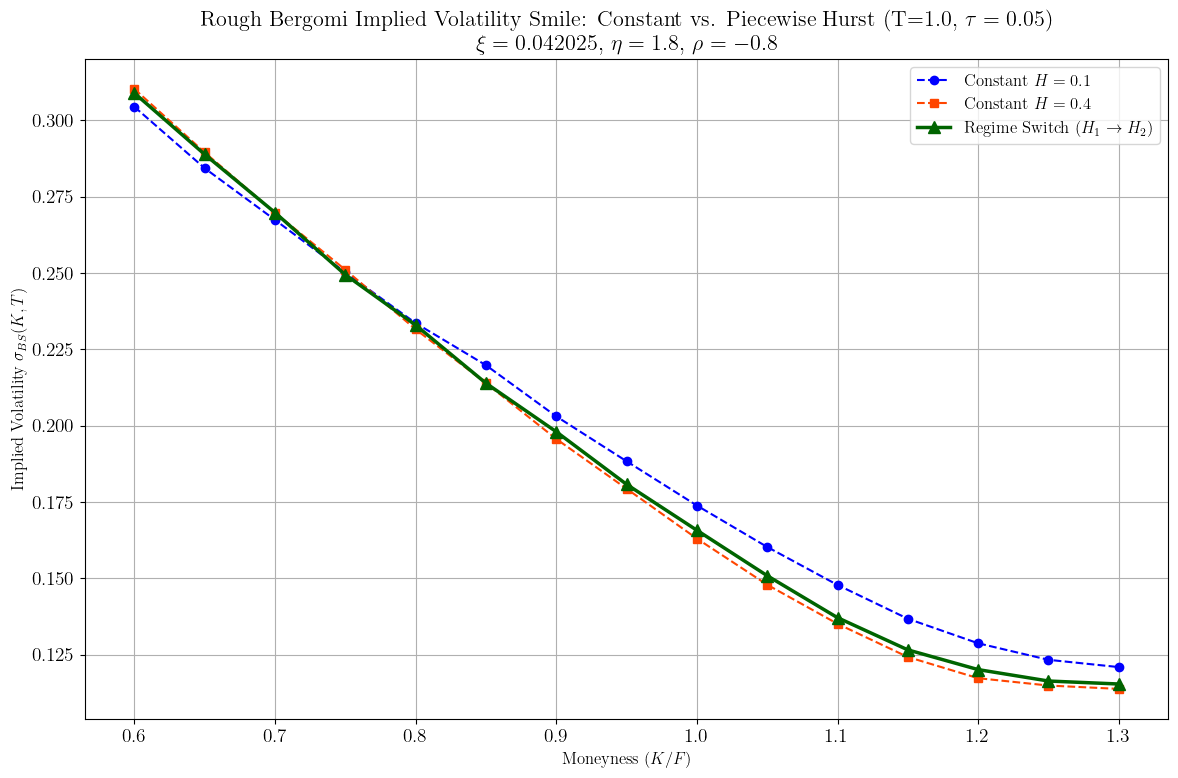

In [14]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 1.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.05
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_1.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile_t_2.png'


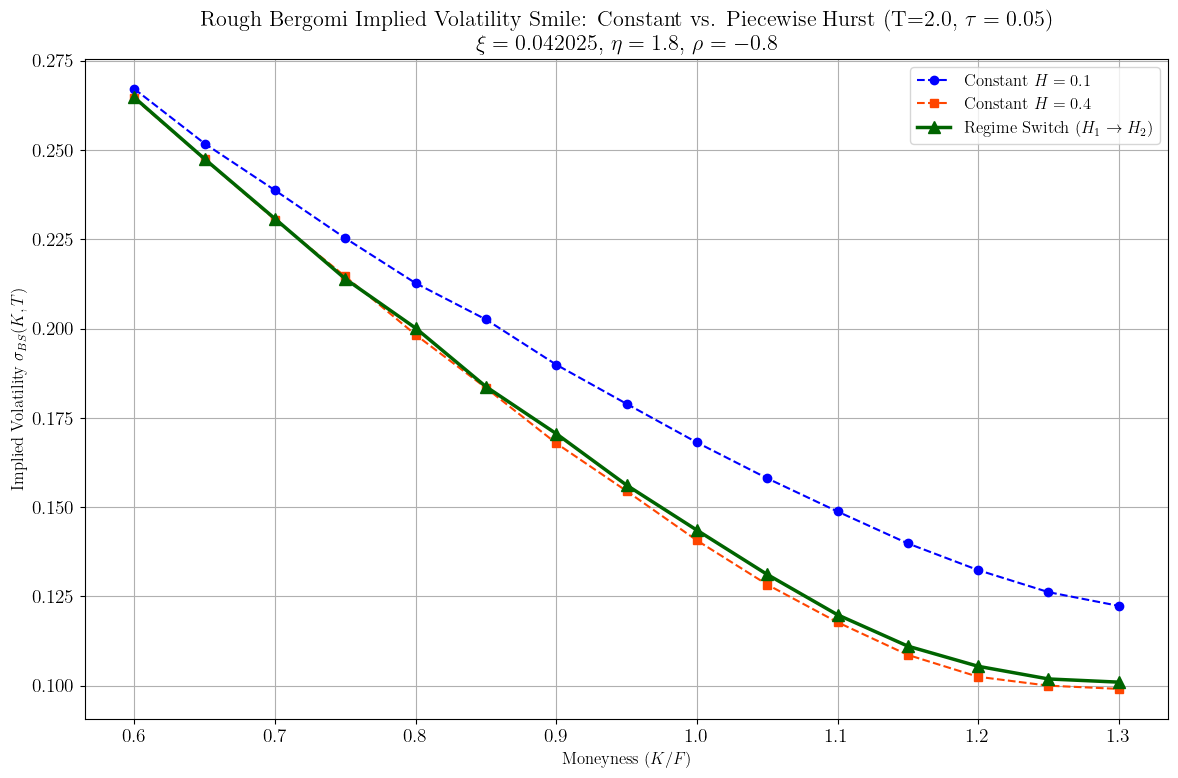

In [15]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 2.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.05
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_2.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile_t_2.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


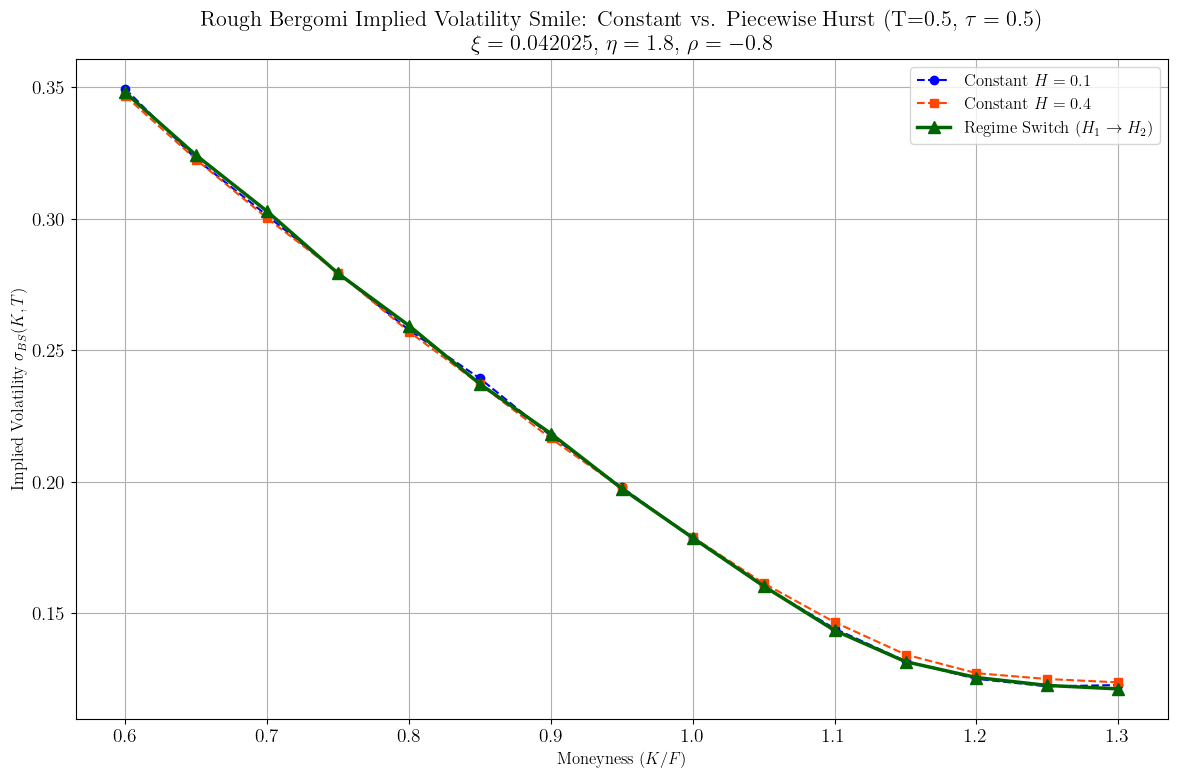

In [17]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 0.5, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.5
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_05_tau.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


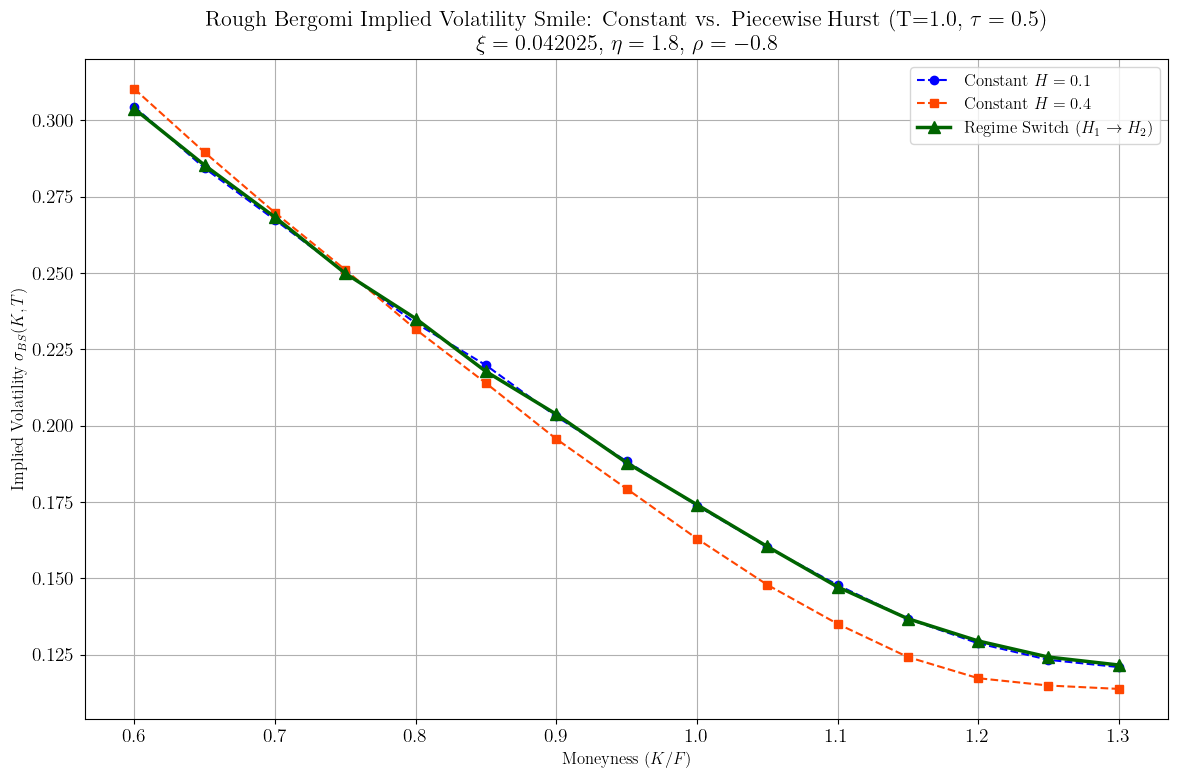

In [18]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 1.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.5
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_1_tau.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


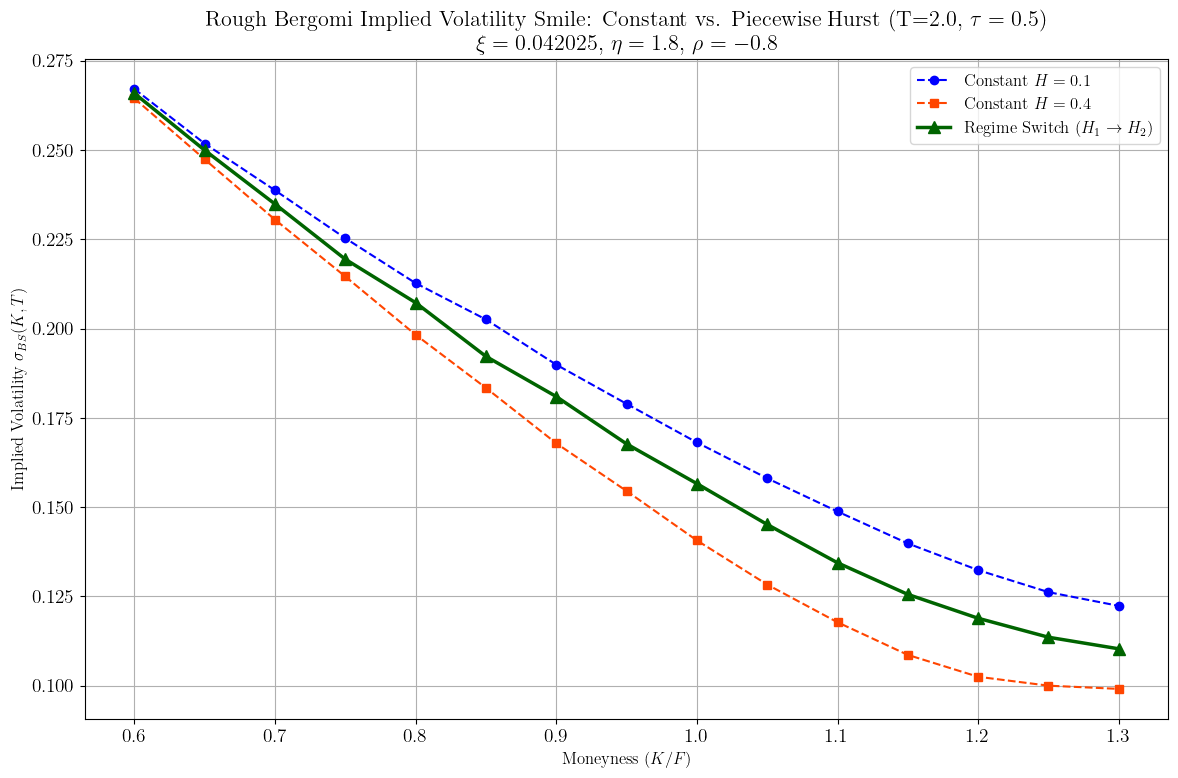

In [20]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 2.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.5
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_2_tau.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


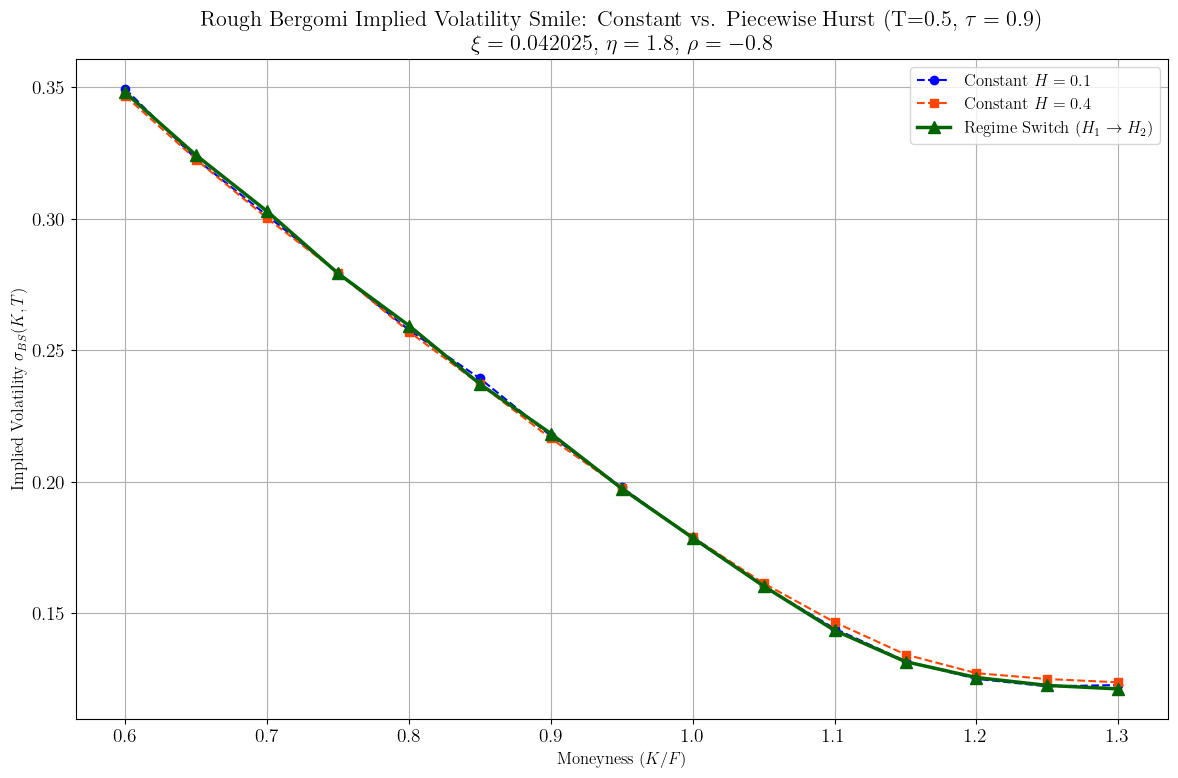

In [27]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 0.5, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.90
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_05_tau_90.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


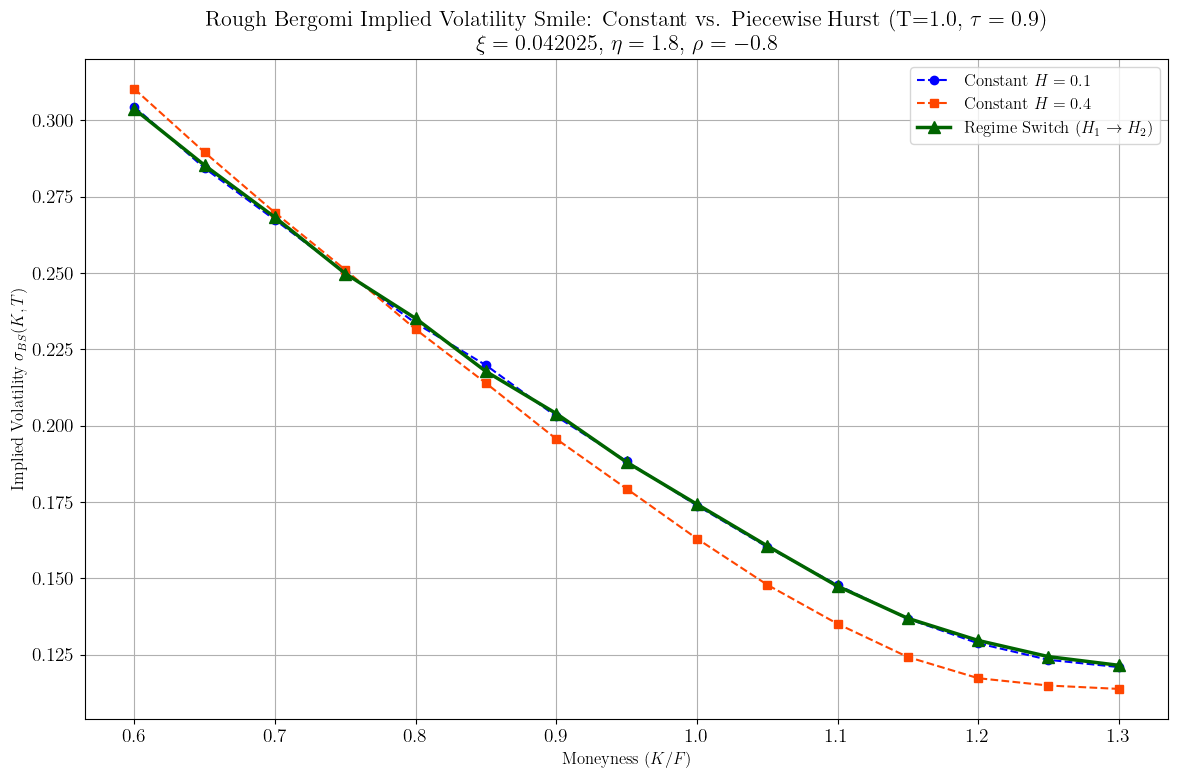

In [28]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 1.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.90
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_1_tau_90.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Starting simulations with the model ---
--- Model 1/3: Constant H=0.1 ---

--- Model 2/3: Constant H=0.4 ---

--- Model 3/3: Regime Switch H=0.1 -> H=0.4 ---

Plot saved as 'regime_switch_smile.png'


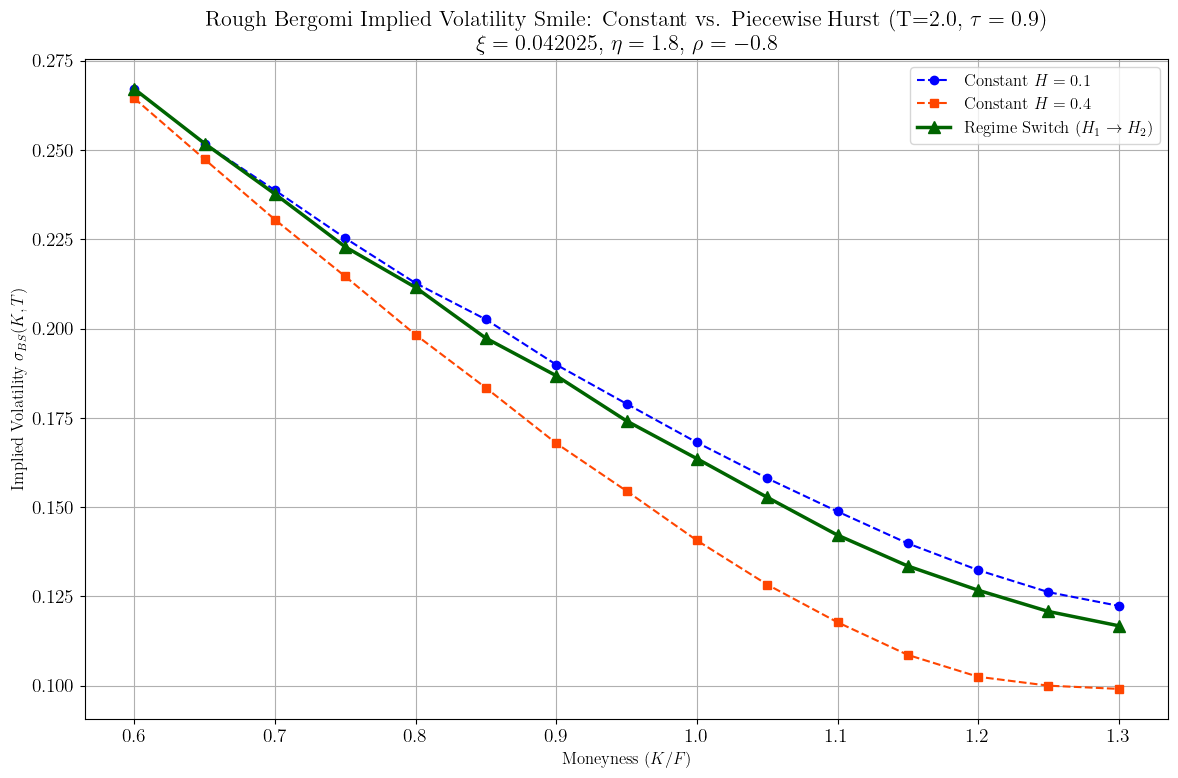

In [29]:
# ==============================================================================
# MAIN SIMULATION AND PLOTTING
# ==============================================================================
# --- Model Parameters ---
S0_main, r_main, q_main = 1.0, 0.0, 0.0
T_main, xi_main, eta_main, rho_main = 2.0, 0.042025, 1.8, -0.8
H1_main, H2_main, T1_main = 0.1, 0.4, 0.90
n_steps, n_paths = 100, 300000
moneyness_k_f = np.linspace(0.6, 1.3, 15)
strikes = S0_main * moneyness_k_f
ivols_h1, ivols_h2, ivols_regime = [], [], []

print("--- Starting simulations with the model ---")

# --- Create isolated Random Number Generators for each model ---
# This is the definitive solution to ensure independence between simulations.
rng_h1 = np.random.default_rng(seed=0)
rng_h2 = np.random.default_rng(seed=1)
rng_regime = np.random.default_rng(seed=2)

# --- Model 1: Constant H = 0.1 ---
print(f"--- Model 1/3: Constant H={H1_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H1_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H1_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h1)
    ivols_h1.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 2: Constant H = 0.4 ---
print(f"\n--- Model 2/3: Constant H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # To simulate a constant H, we pass H2_main as both H1 and H2.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H2_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_h2)
    ivols_h2.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Model 3: Regime Switch H1 -> H2 ---
print(f"\n--- Model 3/3: Regime Switch H={H1_main} -> H={H2_main} ---")
for K in strikes:
    flag = 'c' if K >= S0_main else 'p'
    # Here we use H1_main and H2_main to simulate the regime switch.
    price = price_rbergomi_piecewise_h(K, T_main, T1_main, H1_main, H2_main, eta_main, rho_main, xi_main, S0_main, r_main, q_main, n_steps, n_paths, rng=rng_regime)
    ivols_regime.append(find_implied_vol(price, S0_main, K, T_main, r_main, q_main, flag))

# --- Plot the Results ---
plt.figure(figsize=(12, 8))
plot_with_nan_handling(moneyness_k_f, ivols_h1, marker='o', linestyle='--', color='blue', label=f'Constant $H = {H1_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_h2, marker='s', linestyle='--', color='orangered', label=f'Constant $H = {H2_main}$')
plot_with_nan_handling(moneyness_k_f, ivols_regime, marker='^', linestyle='-', color='darkgreen', lw=2.5, markersize=8, label=f'Regime Switch ($H_1 \\rightarrow H_2$)')

plt.title(f'Rough Bergomi Implied Volatility Smile: Constant vs. Piecewise Hurst (T={T_main}, $\\tau={T1_main}$)\n$\\xi={xi_main}$, $\\eta={eta_main}$, $\\rho={rho_main}$', fontsize=16)
plt.xlabel('Moneyness $(K/F)$', fontsize=12)
plt.ylabel('Implied Volatility $\\sigma_{BS}(K, T)$', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('regime_switch_smile_t_2_tau_90.png', dpi=600)
print("\nPlot saved as 'regime_switch_smile.png'")
plt.show()
plt.close()


--- Simulating a single path for the piecewise rBergomi model ---
Simulation completed in 0.11 seconds.


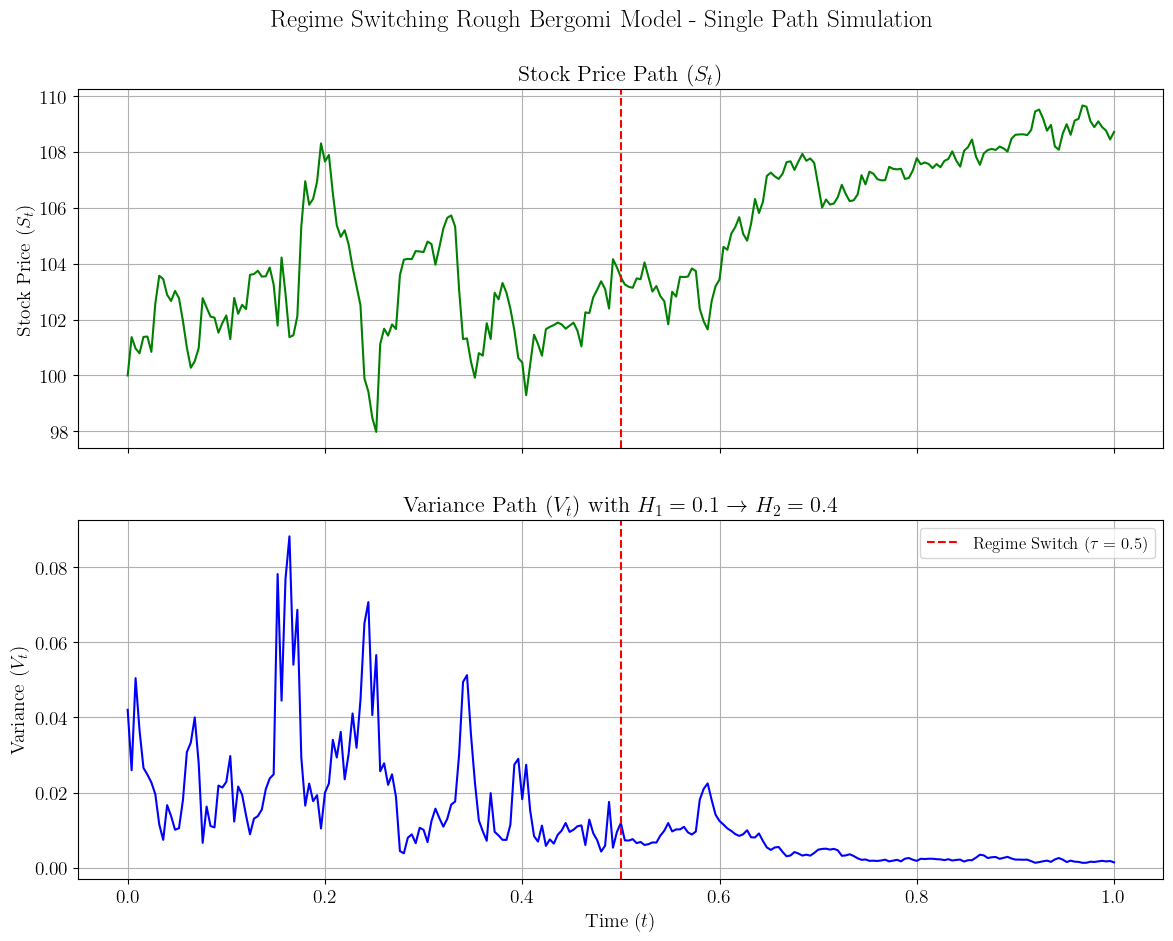

Plot saved successfully as 'rbergomi_single_path_simulation.png'


In [26]:
# ==============================================================================
# SECTION 2: SIMULATION PARAMETERS
# ==============================================================================
# A dictionary to hold all model and simulation parameters for clarity.
params = {
    'T': 1.0,       # Total maturity (1 year)
    'T1': 0.5,      # Regime switch time for Hurst parameter (tau = 0.5 years)
    'H1': 0.1,      # First regime: Very rough (H < 0.5)
    'H2': 0.4,      # Second regime: Smoother, but still in the rough domain
    'eta': 1.8,     # Volatility of volatility parameter
    'rho': -0.8,    # Correlation between the Brownian motions
    'xi': 0.042025,    # Initial forward variance
    'S0': 100.0,      # Initial stock price
    'n_steps': 250  # Number of time steps for a smoother plot
}

# ==============================================================================
# SECTION 3: RUN SIMULATION AND PLOT RESULTS
# ==============================================================================
print("--- Simulating a single path for the piecewise rBergomi model ---")
start_time = time.time()

# Simulate by unpacking the parameters dictionary into the function call.
t, S, V = simulate_rbergomi_piecewise_h_path(**params)

print(f"Simulation completed in {(time.time() - start_time):.2f} seconds.")

# --- Visualize the Results ---
# Create a figure with two subplots that share the same x-axis.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle(r'Regime Switching Rough Bergomi Model - Single Path Simulation', fontsize=18)


# --- Plot 1: Stock Price Path ---
ax1.plot(t, S, color='green')
ax1.axvline(x=params['T1'], color='red', linestyle='--') # Add the switch line
ax1.set_title(r'Stock Price Path ($S_t$)')
ax1.set_ylabel(r'Stock Price ($S_t$)')
ax1.grid(True)


# --- Plot 2: Variance Path ---
ax2.plot(t, V, color='blue')
ax2.axvline(x=params['T1'], color='red', linestyle='--', label=rf'Regime Switch ($\tau={params["T1"]}$)')
ax2.set_title(rf'Variance Path ($V_t$) with $H_1={params["H1"]} \rightarrow H_2={params["H2"]}$')
ax2.set_ylabel(r'Variance ($V_t$)')
ax2.set_xlabel(r'Time ($t$)') # x-axis label only on the bottom plot
ax2.legend()
ax2.grid(True)


# Adjust layout to prevent the main title from overlapping with subplots.
plt.subplots_adjust(top=0.90)
plt.savefig('rbergomi_single_path_simulation.png', dpi=600)
plt.show()
plt.close()
print("Plot saved successfully as 'rbergomi_single_path_simulation.png'")